In [ ]:
# environment
!pip install diffusers==0.27.0 lpips datasets openai-clip huggingface-hub==0.23.4

In [1]:
try:
    import google.colab
    !git clone https://github.com/rhfeiyang/art-free-diffusion.git
    %cd /content/art-free-diffusion
except:
    pass

In [1]:
from diffusers import DiffusionPipeline
import matplotlib.pyplot as plt
import torch

In [2]:
# Load our art-free diffusion model
pipe = DiffusionPipeline.from_pretrained("rhfeiyang/art-free-diffusion-v1").to("cuda")

/data/vision/torralba/selfmanaged/torralba/scratch/jomat/sam_dataset/miniforge3/envs/diffusion/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/data/vision/torralba/selfmanaged/torralba/scratch/jomat/sam_dataset/miniforge3/envs/diffusion/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


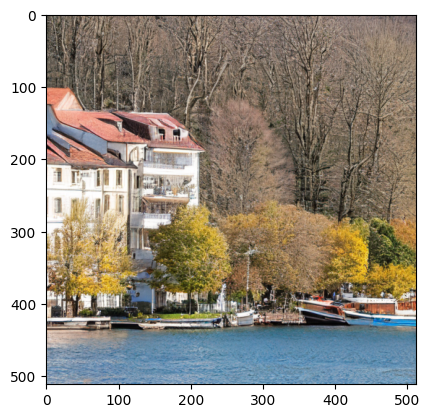

In [3]:
images = pipe("The image depicts a picturesque small town by a river, featuring several docked boats. Surrounded by trees, the town is near a large body of water, highlighting its popularity for boating and water activities. The serene composition, with trees and boats, underscores the town's natural beauty and tranquil charm.",
              num_inference_steps=50, guidance_scale=7.5, generator = torch.Generator().manual_seed(0)
              ).images
plt.imshow(images[0])

Download the Art Adapters

In [4]:
from data.download import download_data
download_data(["art_adapters"], "data")


Art_adapters.zip:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Extracting data/Art_adapters.zip


In [11]:
from inference import get_lora_network, inference, get_validation_dataloader
def demo_inference_gen(adapter_path:str, prompts:list, seed:int=0):
    infer_loader = get_validation_dataloader(prompts)
    network = get_lora_network(pipe.unet, adapter_path,"all_up")["network"]
    pred_images = inference(network, pipe.tokenizer, pipe.text_encoder, pipe.vae, pipe.unet, pipe.scheduler, infer_loader,
                            height=512, width=512, scales=[0.,1.],
                            save_dir=None, seed=seed,steps=50, guidance_scale=7.5,
                            start_noise=-1, show=True, style_prompt="sks art", no_load=True,
                            from_scratch=True)
    return pred_images

def demo_inference_stylization(adapter_path:str, prompts:list, image:list, start_noise=800,seed:int=0):
    infer_loader = get_validation_dataloader(prompts, image)
    network = get_lora_network(pipe.unet, adapter_path,"all_up")["network"]
    pred_images = inference(network, pipe.tokenizer, pipe.text_encoder, pipe.vae, pipe.unet, pipe.scheduler, infer_loader,
                            height=512, width=512, scales=[0.,1.],
                            save_dir=None, seed=seed,steps=50, guidance_scale=7.5,
                            start_noise=start_noise, show=True, style_prompt="sks art", no_load=True,
                            from_scratch=False)
    return pred_images


Art of Derain: Art generation

Rank: 1, Alpha: 1.0
create LoRA for U-Net: 123 modules.
Missing: <All keys matched successfully>
save dir: None
['Park with cherry blossom trees, picnicker’s and a clear blue pond in the style of sks art'] 0


100%|██████████| 51/51 [00:08<00:00,  6.20it/s]


Time taken for one batch 0.0: 8.428056955337524


100%|██████████| 51/51 [00:07<00:00,  6.70it/s]


Time taken for one batch 1.0: 7.815519332885742


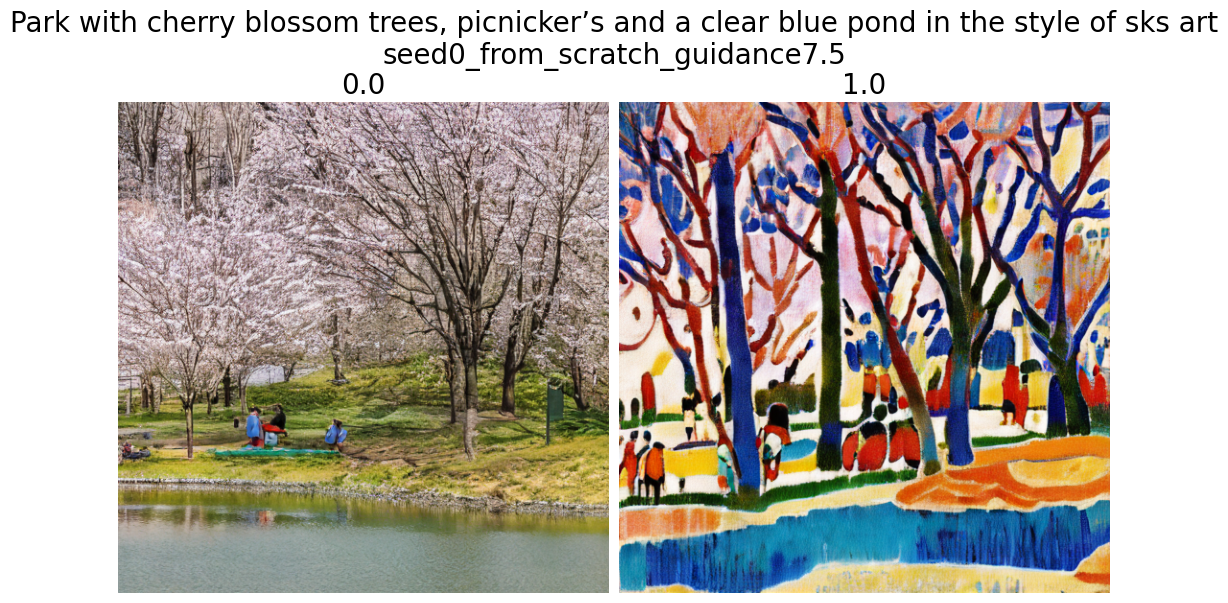

({0.0: [<PIL.Image.Image image mode=RGB size=512x512>],
  1.0: [<PIL.Image.Image image mode=RGB size=512x512>]},
 ['Park with cherry blossom trees, picnicker’s and a clear blue pond in the style of sks art'])

In [7]:
art_adapter_path="data/Art_adapters/andre-derain_subset1/adapter_alpha1.0_rank1_all_up_1000steps.pt"
infer_prompts=["Park with cherry blossom trees, picnicker’s and a clear blue pond."]
demo_inference_gen(art_adapter_path, infer_prompts, seed=0)

Art of Derain: Image Stylization

Rank: 1, Alpha: 1.0
create LoRA for U-Net: 123 modules.
Missing: <All keys matched successfully>
save dir: None
['Snow-covered trees with sunlight shining through in the style of sks art'] 0


100%|██████████| 51/51 [00:07<00:00,  6.76it/s]


Time taken for one batch 0.0: 7.72569727897644


100%|██████████| 51/51 [00:07<00:00,  6.75it/s]


Time taken for one batch 1.0: 7.739068269729614


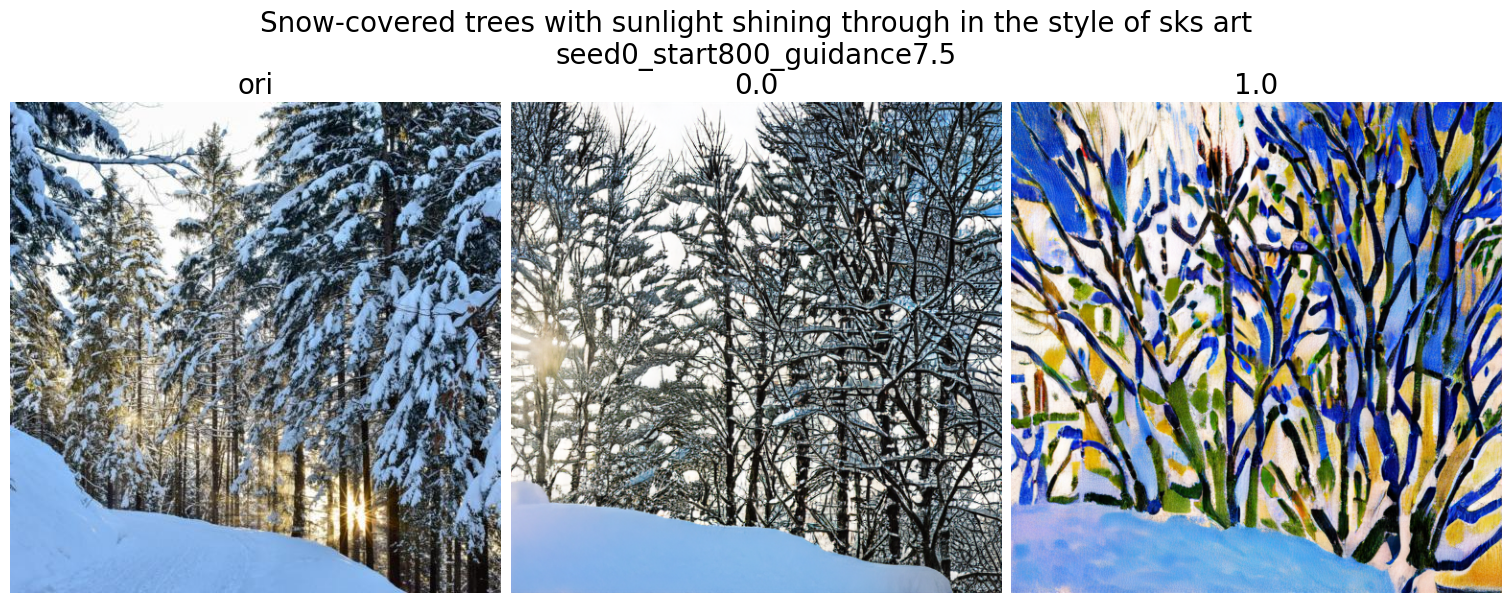

({'ori': [<PIL.Image.Image image mode=RGB size=512x512>],
  0.0: [<PIL.Image.Image image mode=RGB size=512x512>],
  1.0: [<PIL.Image.Image image mode=RGB size=512x512>]},
 ['Snow-covered trees with sunlight shining through in the style of sks art'])

In [12]:
art_adapter_path="data/Art_adapters/andre-derain_subset1/adapter_alpha1.0_rank1_all_up_1000steps.pt"
infer_prompts=["Snow-covered trees with sunlight shining through"]
ref_image=["demo_img/Snow-covered_trees_with_sunlight_shining_through.jpg"]
# the larger start_noise is, the more content changes, the more stylized the image is
demo_inference_stylization(art_adapter_path, infer_prompts, ref_image, start_noise=800, seed=0)